# Описание проекта

Допустим, вы работаете в добывающей компании. Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

#### 1.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#### 1.2 Загрузка и чтение данных

Прочитаем и запишем данные в отдельные переменные:

In [2]:
region_1 = pd.read_csv('/datasets/geo_data_0.csv')
region_2 = pd.read_csv('/datasets/geo_data_1.csv')
region_3 = pd.read_csv('/datasets/geo_data_2.csv')

Для удобства и избежания дублирования кода, напишем функцию, выводящую информацию по датасету.

Нас интересуют следующие характеристики датасета:
- Общая информация
- Наличие пропусков
- Присутствие признаков, которые могут негативно сказаться на работе модели машинного обучения
- Так как целевой признак - объём нефтяных запасов в скважине, следует проверить, присутствуют ли в данном столбце нулевые значения
- Среднее значение запасов нефти в скважинах


В датасете имеется 5 признаков:
- **id** - идентификатор месторождения, который в рамках нашей задачи является лишним
- **f0**, **f1**, **f2** - признаки месторождений
- **product** - целевой признак

In [3]:
def show_info(region, region_name):
    print(region_name, '\n')
    display(region.head(5))
    print(region.info())
    
    #построение таблицы с интересующими нас данными
    info_table = []
    info_table.append([region.isna().values.sum(),
    region.duplicated().sum(),
    region.query('product == 0')['product'].count(),
    (region.query('product == 0')['product'].count() / len(region)) * 100, region['product'].mean()])
    
    #таблица корреляции
    print('\n', 'Индекс корреляции между признаками:')
    display(region.corr().style.applymap(lambda x: 'background-color : lightgreen' if (x<1 and abs(x)>0.5) else ''))    
    
    
    display(pd.DataFrame(info_table, columns=['Пропуски', 'Дубликаты', 'Пустые скважины', '% пустых скважин в регионе',
                                              'Среднее значения запасов нефти']))

#### 1.2.1. Первый регион

In [4]:
show_info(region_1, 'Регион №1')

Регион №1 



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

 Индекс корреляции между признаками:


,f0,f1,f2,product
f0,1,-0.440723,-0.00315334,0.143536
f1,-0.440723,1,0.00172443,-0.192356
f2,-0.00315334,0.00172443,1,0.483663
product,0.143536,-0.192356,0.483663,1


,Пропуски,Дубликаты,Пустые скважины,% пустых скважин в регионе,Среднее значения запасов нефти
0,0,0,1,0.001,92.5


Пропуски в датасете отсуствуют.

Присутствует одна пустая скважина.

Значительной корреляции между признаками нет.

#### 1.2.2. Второй регион

In [5]:
show_info(region_2, 'Регион №2')

Регион №2 



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

 Индекс корреляции между признаками:


,f0,f1,f2,product
f0,1,0.182287,-0.00177704,-0.0304905
f1,0.182287,1,-0.00259532,-0.0101549
f2,-0.00177704,-0.00259532,1,0.999397
product,-0.0304905,-0.0101549,0.999397,1


,Пропуски,Дубликаты,Пустые скважины,% пустых скважин в регионе,Среднее значения запасов нефти
0,0,0,8235,8.235,68.825


Пропуски отсутствуют.

В данном регионе **8.23%** скважин не содержат нефть.

Можно заметить очень сильную положительную корреляцию между признаком **f2** и целевым признаком.

#### 1.2.2. Третий регион

In [6]:
show_info(region_3, 'Регион №3')

Регион №3 



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

 Индекс корреляции между признаками:


,f0,f1,f2,product
f0,1,0.000528283,-0.000448133,-0.00198706
f1,0.000528283,1,0.000778661,-0.00101239
f2,-0.000448133,0.000778661,1,0.445871
product,-0.00198706,-0.00101239,0.445871,1


,Пропуски,Дубликаты,Пустые скважины,% пустых скважин в регионе,Среднее значения запасов нефти
0,0,0,1,0.001,95.0


Пропуски в датасете отсутствуют.<br>
Также как и в первом регионе, присутствует одна пустая скважина.

#### 1.2.3. Общая информация по трём регионам

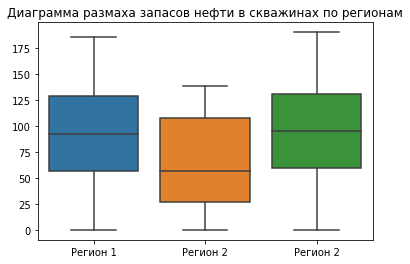

In [7]:
ax = sns.boxplot(data=[region_1['product'], region_2['product'], region_3['product']])
ax.set_title("Диаграмма размаха запасов нефти в скважинах по регионам")
ax.set_xticklabels(['Регион 1','Регион 2','Регион 2'])
plt.show()

In [8]:
stat_table = []

region_dict = {'Регион 1': region_1, 'Регион 2': region_2, 'Регион 3': region_3}

for key, value in region_dict.items():
    #словарь понадобится при обучении модели, так что сразу же отбросим столбец с id скважины
    region_dict[key] = region_dict[key].drop('id', axis=1)
    
    median = value['product'].median()
    q1 = value['product'].quantile(.25)
    q3 = value['product'].quantile(.75)
    min_value = value['product'].min()
    max_value = value['product'].max()
    overall_product = (value['product'].sum() * 450000) / 1_000_000
    
    stat_table.append(
        [key,
        median,
        q1,
        q3,
        min_value,
        max_value,
        overall_product]
    )

columns = ['Регион','Median', 'Q1', 'Q3', 'Min', 'Max', 'Overall product (млн. рублей)']
display(pd.DataFrame(stat_table, columns=columns))

,Регион,Median,Q1,Q3,Min,Max,Overall product (млн. рублей)
0,Регион 1,91.849972,56.497507,128.564089,0.0,185.364347,4162500.0
1,Регион 2,57.085625,26.953261,107.813044,0.0,137.945408,3097125.0
2,Регион 3,94.925613,59.450441,130.595027,0.0,190.029838,4275000.0


**Выводы по шагу:**

- Данные были подготовлены для обучения модели. Провели проверку на наличие пропусков и дубликатов.
- В каждом регионе присутствуют пустые скважины, но сильнее всего их количество выражено в регионе №2 - **8.235** от общего количества скважин в регионе
- Выяснили, что, в среднем, в третьем регионе среднее значение объёма запасов нефти больше, чем в других регионах
- Во втором регионе наименьшее среднее значение количества объёма запасов нефти меньше при большом количестве пустых месторождений.
- Во втором регионе наблюдается аномальная корреляция между признаком **f2** и и целевым признаком **product** - индекс корреляции равен **0.999**

# 2. Обучение и проверка модели

Обучим модель.

В цикле резделим датасет на обучающую и валидационную выборку, сделаем и сохраним предсказания на валидационной выборке и напечатаем информацию на основе предсказаний модели.

In [9]:
results = []

for key, value in region_dict.items():
    features = value.drop('product', axis=1)
    target = value['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                                  test_size=0.25, random_state=42)
    #проверим размер выборок:
    print(key)
    print('Размер обучающей выборки:', features_train.shape)
    print('Размер валидационной выборки:', features_valid.shape, '\n')
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predictions)
    rmse = mse ** 0.5
    mean = predictions.mean()
    
    #запишем результаты работы моделей в список словарей:
    results.append({'Регион': key,
                    'MSE': mse,
                    'RMSE': rmse,
                    'Predicted mean': mean,
                    'Actual mean': value['product'].mean(),
                    'features_train': features_train,
                    'target_train': target_train,
                    'features_valid': features_valid,
                    'target_valid': target_valid,
                    'predictions': predictions})
    
#выведем результат на экран:
display(pd.DataFrame(results)[['Регион', 'MSE', 'RMSE', 'Predicted mean', 'Actual mean']])

Регион 1
Размер обучающей выборки: (75000, 3)
Размер валидационной выборки: (25000, 3) 

Регион 2
Размер обучающей выборки: (75000, 3)
Размер валидационной выборки: (25000, 3) 

Регион 3
Размер обучающей выборки: (75000, 3)
Размер валидационной выборки: (25000, 3) 



,Регион,MSE,RMSE,Predicted mean,Actual mean
0,Регион 1,1425.560870,37.756600,92.398800,92.500
1,Регион 2,0.792599,0.890280,68.712878,68.825
2,Регион 3,1611.691064,40.145872,94.771024,95.000


**Выводы по шагу:**
- Предсказанные средние значения практически не отличаются от фактических средних значений
- Во втором регионе показатель метрики RMSE близок к идеальному и это может быть обусловлено достаточно ярко выраженной корреляцией между признаком **f2** и целевым признаком (что является достаточно странным явлением, т.к. данный признак выглядит как показатель гипотетического датчика запасов месторождения нефти, но только для второго региона - в других регионах подобной зависимости признаков замечено не было)
- показатели **RMSE** в регионе 1 и 3 выглядят схожими и, учитывая то, что предсказанные и фактические значения запасов по всем регионам также отличаются незначительно, можно сделать вывод, что предсказания данных моделей годятся для дальнейшей работы.

# 3. Подготовка к расчёту прибыли

Сохраним все ключевые значения для рассчётов в отдельные константы.<br>
Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.<br>
Сравним полученный объём сырья со средним запасом в каждом регионе.<br>

In [10]:
ALL_POINTS = 500
BEST_POINTS = 200
BUDGET = 10_000_000_000
PROFIT_PER_BARREL = 450_000
THRESHOLD = .025
BUDGET_POINT = BUDGET / BEST_POINTS

In [11]:
print('Достаточный объём сырья для безубыточной разработки новой скважины:', BUDGET_POINT / PROFIT_PER_BARREL, '\n')
print('Средний объём сырья по регионам:', '\n')
for key, value in region_dict.items():
    print(key+':', value['product'].mean())

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11111111111111 

Средний объём сырья по регионам: 

Регион 1: 92.50000000000001
Регион 2: 68.82500000000002
Регион 3: 95.00000000000004


**Вывод по шагу:** Для безубыточной разработки новой скважины необходимо переработать как минимум 111.1 единиц продукта - средний обьём сырья во всех регионах меньше данного значения.

# 4. Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.<br>
Выберем скважины с максимальными значениями предсказаний.<br>
Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.<br>
Рассчитаем прибыль для полученного объёма сырья.

Применим технику bootstrap и выведем необходимую нам информацию: среднюю прибыль, 95% доверительный интервал и риск убытков по регионам.

In [12]:
def revenue(target, probabilities, count):
    
    probs_best = probabilities.sort_values(ascending = False).head(count).index
    income = target[probs_best].sum() * PROFIT_PER_BARREL
    
    #переведём в миллионы для лучшего восприятия
    revenue = (income - BUDGET) / 1_000_000
    return revenue

In [13]:
state = np.random.RandomState(42)
bootstrap = []

#итеративно вытаскиваем из списка словарей ранее собранные данные по регионам
for index, dictionary in enumerate(results):
    target = dictionary.get('target_valid')
    predictions = pd.Series(dictionary.get('predictions'), index=target_valid.index)
    
    values = []
    
    for i in range(1000):
        target_subsample = target.sample(n=ALL_POINTS, replace=True, random_state=state)
        prob_subsample = predictions[target_subsample.index]
    
        values.append(revenue(target_subsample, prob_subsample, BEST_POINTS))
    
    values = pd.Series(values)
    
    lower = values.quantile(THRESHOLD)
    upper = values.quantile(.975)
    conf_interval = upper - lower
    risk = (values < 0).sum() / values.count() * 100
    mean = values.mean()

    bootstrap.append({'Регион:': dictionary['Регион'],
                        'Lower': lower,
                        'Upper': upper,
                        'conf_interval_length': conf_interval,
                        'Risk %': risk,
                        'Mean': mean})

In [14]:
#выведем собранную информацию на экран
pd.DataFrame(bootstrap)

,Регион:,Lower,Upper,conf_interval_length,Risk %,Mean
0,Регион 1,10.089412,1246.370981,1236.281569,2.5,606.122632
1,Регион 2,148.800011,1186.977426,1038.177415,0.3,662.413205
2,Регион 3,2.464801,1254.827361,1252.362560,2.5,592.052021


**Вывод по шагу**: наибольший показатель средней прибыли во втором регионе, как и наименьший риск убытков. Чуть меньший показатель средней прибыли у первого региона, но показатель риска убытков находится на границе допустимого значения.

Можем наблюдать, что у второго региона доверительный интервал уже, чем таковой у других регионов.

Проанализировав эти показатели в целом, можно сказать, что регион под номером 2 является более предпочтительным для разработки месторождений нефти.